In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus as pp
import seaborn as sns

from IPython.display import display
from IPython.display import Image

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor

In [2]:
class CONFIG:
    INDEXS = ["R2 Pred", "R2", "EV", "ME", "MEAN_AE", "MSE", "MEDIAN_AE", "HIT@10", "HIT@100"]

# Load Dataset

In [3]:
header = pd.read_csv("Dataset/header.csv", header=None)
header

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable


In [4]:
training_dataset = pd.read_csv("Dataset/Training/Features_Variant_5.csv",
                               header=None,
                               names=[header.iat[0, i] for i in range(0, 54)])
training_dataset.sample(n=10)

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
138054,4926,0,58,68,0.0,3.0,0.361257,0.0,0.686723,0.0,...,0,1,0,0,1,0,0,0,0,0
155646,11384,0,226,2,0.0,58.0,15.112827,13.5,9.520716,0.0,...,0,0,0,0,0,0,1,0,0,0
33981,253349,0,1888,44,0.0,69.0,4.776316,2.0,7.395349,0.0,...,0,0,0,0,0,1,0,0,0,1
145168,8070687,421,278406,9,0.0,1683.0,395.721060,264.0,357.056684,0.0,...,0,0,0,0,0,0,1,0,0,17
46114,8035,608,69,32,0.0,50.0,4.104348,2.0,7.371359,0.0,...,0,0,0,0,0,0,0,1,0,2
181195,1548,0,581,16,0.0,169.0,8.020588,3.0,19.770362,0.0,...,0,0,0,0,0,1,0,0,0,78
8294,115669,0,745,1,0.0,29.0,1.647587,0.0,3.748452,0.0,...,0,0,0,0,1,0,0,0,0,0
31639,1422427,0,35610,9,0.0,214.0,34.748307,19.0,40.813882,0.0,...,0,0,0,0,0,0,0,1,0,4
138563,316982,0,61205,42,0.0,190.0,16.994751,7.0,27.490585,0.0,...,0,1,0,0,0,0,0,0,1,5
171494,22665,0,15605,92,0.0,251.0,47.831340,36.0,44.013064,0.0,...,0,0,1,0,0,0,0,0,0,0


# Data Preprocessing

In [5]:
post_published_weekday = (training_dataset["Post published weekday-Monday"]
                          + training_dataset["Post published weekday-Tuesday"]
                          + training_dataset["Post published weekday-Wednesday"]
                          + training_dataset["Post published weekday-Thursday"]
                          + training_dataset["Post published weekday-Friday"]).astype("int")
post_published_weekend = (training_dataset["Post published weekday-Sunday"]
                          + training_dataset["Post published weekday-Saturday"]).astype("int")
training_dataset.insert(46, "Post published weekday", post_published_weekday)
training_dataset.insert(47, "Post published weekend", post_published_weekend)
training_dataset.drop(
    ["Post published weekday-Saturday",
     "Post published weekday-Sunday",
     "Post published weekday-Monday",
     "Post published weekday-Tuesday",
     "Post published weekday-Wednesday",
     "Post published weekday-Thursday",
     "Post published weekday-Friday"], axis = 1, inplace = True)
training_dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday,Post published weekend,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,1,0,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,1,0,0,0,0,0,0,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,0,0,1,0
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,1,0,0,0,0,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,203
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,42
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,51
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,0,1,0,0,17


In [6]:
base_datetime_weekday = (training_dataset["Base DateTime weekday-Monday"]
                          + training_dataset["Base DateTime weekday-Tuesday"]
                          + training_dataset["Base DateTime weekday-Wednesday"]
                          + training_dataset["Base DateTime weekday-Thursday"]
                          + training_dataset["Base DateTime weekday-Friday"]).astype("int")
base_datetime_weekend = (training_dataset["Base DateTime weekday-Sunday"]
                          + training_dataset["Base DateTime weekday-Saturday"]).astype("int")
training_dataset.insert(48, "Base DateTime weekday", base_datetime_weekday)
training_dataset.insert(49, "Base DateTime weekend", base_datetime_weekend)
training_dataset.drop(
    ["Base DateTime weekday-Saturday",
     "Base DateTime weekday-Sunday",
     "Base DateTime weekday-Monday",
     "Base DateTime weekday-Tuesday",
     "Base DateTime weekday-Wednesday",
     "Base DateTime weekday-Thursday",
     "Base DateTime weekday-Friday"], axis = 1, inplace = True)
training_dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Base time,Post length,Post Share Count,Post Promotion Status,H Local,Post published weekday,Post published weekend,Base DateTime weekday,Base DateTime weekend,Target Variable
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,25,166,2,0,24,1,0,1,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,70,132,1,0,24,1,0,0,1,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,26,133,2,0,24,1,0,0,1,0
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,67,131,1,0,24,1,0,1,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,65,142,5,0,24,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,16,77,2123,0,24,1,0,1,0,203
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,4,130,474,0,24,1,0,1,0,42
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,12,12,1511,0,24,1,0,1,0,51
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,31,149,1099,0,24,1,0,1,0,17


In [7]:
features = training_dataset.iloc[:, :43]
features

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,CC5,Base time,Post length,Post Share Count,Post Promotion Status,H Local,Post published weekday,Post published weekend,Base DateTime weekday,Base DateTime weekend
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,25,166,2,0,24,1,0,1,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,70,132,1,0,24,1,0,0,1
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,26,133,2,0,24,1,0,0,1
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,67,131,1,0,24,1,0,1,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,65,142,5,0,24,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1940,16,77,2123,0,24,1,0,1,0
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,155,4,130,474,0,24,1,0,1,0
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,207,12,12,1511,0,24,1,0,1,0
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,-459,31,149,1099,0,24,1,0,1,0


In [8]:
labels = training_dataset.iloc[:, -1:]
labels

,Target Variable
0,0
1,0
2,0
3,0
4,0
...,...
199025,203
199026,42
199027,51
199028,17


In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.3, random_state=42)

# Cat Boost Regressor

## Model Training

In [10]:
def train_model(model):
    model.fit(X_train, y_train.values.ravel())
    predict = model.predict(X_test)
    return predict

In [11]:
def plot_test_predict(y_train, y_test, predict, axes=None, k=None):
    test_predict = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(predict.transpose())], axis=1)
    headers = ["Test", "Predict"]
    test_predict.columns = headers
    if axes is not None and k is not None:
        sns.lineplot(data=test_predict.sample(n=200), ax=axes[k]).set_title("Test Predict Curve k = " + str(k))
    else:
        sns.lineplot(data=test_predict.sample(n=200)).set_title("Test Predict Curve")
    plt.show()
    sns.residplot(x=predict, y=y_test.to_numpy(), lowess=True).set_title("Residuals")
    plt.show()
    y_test_np = y_test.to_numpy().flatten()
    sns.residplot(x=predict, y=y_test_np * (predict - y_test_np), lowess=True).set_title("Residuals")
    plt.show()

## Model Evaluation

In [12]:
def evaluate(model, X_test, y_test, predict):

    # R-Squared Prediction
    r2_pred = model.score(X_test, y_test)
    
    # R-Squared
    r2 = r2_score(y_test, predict)
    
    # Explained Variance Score
    ev = explained_variance_score(y_test, predict)
    
    # Max Error
    me = max_error(y_test, predict)
    
    # Mean Absolute Error
    mean_ae = mean_absolute_error(y_test, predict)
    
    # Mean Squared Error
    mse = mean_squared_error(y_test, predict)
    
    # Median Absolute Error
    median_ae = median_absolute_error(y_test, predict)
    
    # Hit@10
    y_test_np = y_test.to_numpy().flatten()
    hit = np.abs(y_test_np - predict) < 10
    hit_10 = np.sum(hit) / hit.shape[0]
    
    # Hit@100
    y_test_np = y_test.to_numpy().flatten()
    ordered_y_test = np.argsort(y_test_np)
    max_y_test = ordered_y_test[-100:]
    ordered_predict = np.argsort(predict)
    max_predict = ordered_predict[-100:]
    acc = 0
    for pred in max_predict:
        if pred in max_y_test:
            acc += 1
    hit_100 = acc / 100
    
    return r2_pred, r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100

## Final Model

In [13]:
def train_final_model(max_depth=None, learning_rate=0.5, n_estimators=100):
    # CatBoostRegressor
    model = CatBoostRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        random_state=42,
    )

    # Model Training
    predict = train_model(model)
    plot_test_predict(y_train, y_test, predict)

    # Model Evaluation
    r2_pred, r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100 = evaluate(model, X_test, y_test, predict)

    results = pd.DataFrame({
        "Index": CONFIG.INDEXS, 
        "Mean": [r2_pred, r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100]
    })
    print(results)

0:	learn: 33.2721061	total: 280ms	remaining: 2m 19s
1:	learn: 31.6284839	total: 475ms	remaining: 1m 58s
2:	learn: 30.1660323	total: 719ms	remaining: 1m 59s
3:	learn: 28.8420508	total: 929ms	remaining: 1m 55s
4:	learn: 27.6059002	total: 1.12s	remaining: 1m 50s
5:	learn: 26.5406853	total: 1.36s	remaining: 1m 52s
6:	learn: 25.6194443	total: 1.63s	remaining: 1m 54s
7:	learn: 24.7895815	total: 1.83s	remaining: 1m 52s
8:	learn: 24.0143076	total: 2.02s	remaining: 1m 50s
9:	learn: 23.3274053	total: 2.21s	remaining: 1m 48s
10:	learn: 22.6690621	total: 2.42s	remaining: 1m 47s
11:	learn: 22.1042970	total: 2.66s	remaining: 1m 48s
12:	learn: 21.5933482	total: 2.85s	remaining: 1m 46s
13:	learn: 21.1033404	total: 3.05s	remaining: 1m 45s
14:	learn: 20.6929940	total: 3.25s	remaining: 1m 44s
15:	learn: 20.2781899	total: 3.45s	remaining: 1m 44s
16:	learn: 19.9072129	total: 3.65s	remaining: 1m 43s
17:	learn: 19.5739807	total: 3.84s	remaining: 1m 42s
18:	learn: 19.2368983	total: 4.03s	remaining: 1m 41s
19:

156:	learn: 9.5624587	total: 30s	remaining: 1m 5s
157:	learn: 9.5320529	total: 30.2s	remaining: 1m 5s
158:	learn: 9.5013543	total: 30.4s	remaining: 1m 5s
159:	learn: 9.4739182	total: 30.5s	remaining: 1m 4s
160:	learn: 9.4668828	total: 30.7s	remaining: 1m 4s
161:	learn: 9.4351658	total: 30.9s	remaining: 1m 4s
162:	learn: 9.4198283	total: 31.1s	remaining: 1m 4s
163:	learn: 9.4049774	total: 31.3s	remaining: 1m 4s
164:	learn: 9.3775392	total: 31.5s	remaining: 1m 3s
165:	learn: 9.3486463	total: 31.6s	remaining: 1m 3s
166:	learn: 9.3159172	total: 31.8s	remaining: 1m 3s
167:	learn: 9.3033279	total: 32s	remaining: 1m 3s
168:	learn: 9.2740241	total: 32.2s	remaining: 1m 3s
169:	learn: 9.2416721	total: 32.4s	remaining: 1m 2s
170:	learn: 9.2185805	total: 32.5s	remaining: 1m 2s
171:	learn: 9.1937115	total: 32.7s	remaining: 1m 2s
172:	learn: 9.1684251	total: 32.9s	remaining: 1m 2s
173:	learn: 9.1371956	total: 33.1s	remaining: 1m 2s
174:	learn: 9.1149642	total: 33.3s	remaining: 1m 1s
175:	learn: 9.09

316:	learn: 6.8698319	total: 59.4s	remaining: 34.3s
317:	learn: 6.8613952	total: 59.6s	remaining: 34.1s
318:	learn: 6.8467486	total: 59.8s	remaining: 33.9s
319:	learn: 6.8252528	total: 60s	remaining: 33.7s
320:	learn: 6.8117629	total: 1m	remaining: 33.5s
321:	learn: 6.7998734	total: 1m	remaining: 33.4s
322:	learn: 6.7850770	total: 1m	remaining: 33.2s
323:	learn: 6.7652551	total: 1m	remaining: 33s
324:	learn: 6.7583667	total: 1m	remaining: 32.8s
325:	learn: 6.7440800	total: 1m 1s	remaining: 32.6s
326:	learn: 6.7382291	total: 1m 1s	remaining: 32.4s
327:	learn: 6.7289399	total: 1m 1s	remaining: 32.2s
328:	learn: 6.7151505	total: 1m 1s	remaining: 32s
329:	learn: 6.7088787	total: 1m 1s	remaining: 31.9s
330:	learn: 6.6978262	total: 1m 2s	remaining: 31.7s
331:	learn: 6.6820489	total: 1m 2s	remaining: 31.5s
332:	learn: 6.6683893	total: 1m 2s	remaining: 31.3s
333:	learn: 6.6547880	total: 1m 2s	remaining: 31.1s
334:	learn: 6.6413568	total: 1m 2s	remaining: 30.9s
335:	learn: 6.6272554	total: 1m 2

473:	learn: 5.4085567	total: 1m 29s	remaining: 4.88s
474:	learn: 5.4047244	total: 1m 29s	remaining: 4.69s
475:	learn: 5.3941931	total: 1m 29s	remaining: 4.51s
476:	learn: 5.3840454	total: 1m 29s	remaining: 4.32s
477:	learn: 5.3726036	total: 1m 29s	remaining: 4.13s
478:	learn: 5.3615678	total: 1m 29s	remaining: 3.94s
479:	learn: 5.3514490	total: 1m 30s	remaining: 3.76s
480:	learn: 5.3400484	total: 1m 30s	remaining: 3.57s
481:	learn: 5.3366159	total: 1m 30s	remaining: 3.38s
482:	learn: 5.3287989	total: 1m 30s	remaining: 3.19s
483:	learn: 5.3225292	total: 1m 30s	remaining: 3s
484:	learn: 5.3165285	total: 1m 31s	remaining: 2.82s
485:	learn: 5.3075640	total: 1m 31s	remaining: 2.63s
486:	learn: 5.2963499	total: 1m 31s	remaining: 2.44s
487:	learn: 5.2859591	total: 1m 31s	remaining: 2.25s
488:	learn: 5.2795271	total: 1m 31s	remaining: 2.07s
489:	learn: 5.2707607	total: 1m 32s	remaining: 1.88s
490:	learn: 5.2642507	total: 1m 32s	remaining: 1.69s
491:	learn: 5.2561518	total: 1m 32s	remaining: 1.

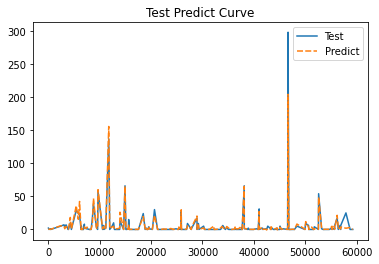

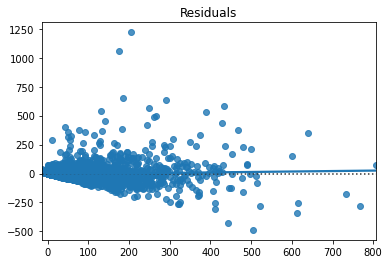

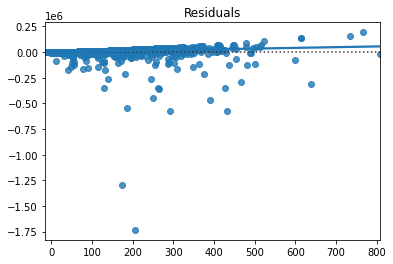

       Index           Mean
0    R2 Pred -102132.741334
1         R2       0.733098
2         EV       0.733101
3         ME    1224.095139
4    MEAN_AE       3.275103
5        MSE     273.874015
6  MEDIAN_AE       0.526241
7     HIT@10       0.939858
8    HIT@100       0.590000


In [14]:
train_final_model(max_depth=12, learning_rate=0.1, n_estimators=1000)